# 🙋‍♂️ Вступление

Здравствуйте! 

> Перед нами данные от телеком компании. Даны 500 уникальных клиентов которые пользуются двумя тарифами. Нужно сравнить их поведение, чтобы выяснить какой тарифный план "лучше". Для этого проекта необходимо по условию, использовать критерий Стьюдента, а также объяснить почему именно он. Файлы представлены в 5 датасетах, нужно их соеденить в одну большую таблицу, но прежде надо агрегировать данные.

## Бриф:

**Описание тарифов:**

Тариф **«Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

Тариф **«Ультра»**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей


**Примечание**:

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

# 📚 1. Импорт

In [ ]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from scipy import stats as st
import pylab 

warnings.filterwarnings("ignore")

# 📞 2. Загрузка файла

In [ ]:
call = pd.read_csv('/content/calls.csv')
internet = pd.read_csv('/content/internet.csv', index_col=0)
message = pd.read_csv('/content/messages.csv')
tariff = pd.read_csv('/content/tariffs.csv')
user = pd.read_csv('/content/users.csv')

In [ ]:
call.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [ ]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [ ]:
message.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
tariff.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [ ]:
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


# 💡 3. Описание данных и предобработка

Таблица **user** (информация о пользователях):

- **user_id** — уникальный идентификатор пользователя
- **first_name** — имя пользователя
- **last_name** — фамилия пользователя
- **age** — возраст пользователя (годы)
- **reg_date** — дата подключения тарифа (день, месяц, год)
- **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- **city** — город проживания пользователя
- **tariff** — название тарифного плана

Таблица **call** (информация о звонках):

- **id** — уникальный номер звонка
- **call_date** — дата звонка
- **duration** — длительность звонка в минутах
- **user_id** — идентификатор пользователя, сделавшего звонок



Таблица **message** (информация о сообщениях):

- **id** — уникальный номер сообщения
- **message_date** — дата сообщения
- **user_id** — идентификатор пользователя, отправившего сообщение



Таблица **internet** (информация об интернет-сессиях):

- **id** — уникальный номер сессии
- **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
- **session_date** — дата интернет-сессии
- **user_id** — идентификатор пользователя




Таблица **tariff** (информация о тарифах):

- **tariff_name** — название тарифа
- **rub_monthly_fee** — ежемесячная абонентская плата в рублях
- **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
- **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
- **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
- **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [ ]:
print(call['call_date'].min())
print(call['call_date'].max())

2018-01-01
2018-12-31


- данные представленый в периоде за 1 год
- формат даты представлен как object заменим на формат даты
- необходимо округлить минуты звонков до целых минут в большую сторону
- сделаем агрегацию данных по каждому пользователю

## 3.1 Замена типа данных

In [ ]:
call['call_date'] = pd.to_datetime(call['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
message['message_date'] = pd.to_datetime(message['message_date'], format='%Y-%m-%d')
user['reg_date'] = pd.to_datetime(user['reg_date'], format='%Y-%m-%d')
user['churn_date'] = pd.to_datetime(user['churn_date'], format='%Y-%m-%d')

## 3.2 Округление минут

In [ ]:
call['duration'] = np.ceil(call['duration']).astype(int)

## 3.3 Агрегирование данных

In [ ]:
call['month'] = call['call_date'].astype('datetime64[M]')
call_agr = call.groupby(['user_id', 'month'])['duration'].sum().reset_index()
call_agr.head()

,user_id,month,duration
0,1000,2018-05-01,159
1,1000,2018-06-01,172
2,1000,2018-07-01,340
3,1000,2018-08-01,408
4,1000,2018-09-01,466


In [ ]:
internet['month'] = internet['session_date'].astype('datetime64[M]')
internet_agr = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_agr.head()

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91


In [ ]:
message['month'] = message['message_date'].astype('datetime64[M]')
message_agr = message.groupby(['user_id', 'month'])['id'].count().reset_index()
message_agr.rename(columns={'id': 'sms_count'}, inplace=True)
message_agr.head()

,user_id,month,sms_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


## 3.4 Джоин таблиц в одну

In [ ]:
df = (
    call_agr
            .merge(internet_agr, on=['user_id', 'month'], how='outer')
            .merge(message_agr, on=['user_id', 'month'], how='outer')
            .merge(user, on=['user_id'], how='outer')
)

In [ ]:
df.head()

,user_id,month,duration,mb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,159.0,2253.49,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,172.0,23233.77,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,340.0,14003.64,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,408.0,14055.93,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,466.0,14568.91,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3216 non-null   int64         
 1   month       3214 non-null   datetime64[ns]
 2   duration    3174 non-null   float64       
 3   mb_used     3203 non-null   float64       
 4   sms_count   2717 non-null   float64       
 5   age         3216 non-null   int64         
 6   churn_date  189 non-null    datetime64[ns]
 7   city        3216 non-null   object        
 8   first_name  3216 non-null   object        
 9   last_name   3216 non-null   object        
 10  reg_date    3216 non-null   datetime64[ns]
 11  tariff      3216 non-null   object        
dtypes: datetime64[ns](3), float64(3), int64(2), object(4)
memory usage: 326.6+ KB


## 3.5 Заполнение пропусков, изменение типа

In [ ]:
df = df.fillna(0)

- Обнаружено что 2 пользователя заргестрированы в декабре, затем они сменили тарифы, удалим этих польщователй из таблицы.

In [ ]:
df = df.query('month != 0').reset_index(drop=True)

In [ ]:
df['month'] = df['month'].astype('datetime64[M]')
df['duration'] = df['duration'].astype(int)
df['mb_used'] = np.ceil(df['mb_used']).astype(int)
df['sms_count'] = df['sms_count'].astype(int)

In [ ]:
df.head()

,user_id,month,duration,mb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,159,2254,22,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,172,23234,60,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,340,14004,75,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,408,14056,81,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,466,14569,57,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3214 non-null   int64         
 1   month       3214 non-null   datetime64[ns]
 2   duration    3214 non-null   int64         
 3   mb_used     3214 non-null   int64         
 4   sms_count   3214 non-null   int64         
 5   age         3214 non-null   int64         
 6   churn_date  3214 non-null   object        
 7   city        3214 non-null   object        
 8   first_name  3214 non-null   object        
 9   last_name   3214 non-null   object        
 10  reg_date    3214 non-null   datetime64[ns]
 11  tariff      3214 non-null   object        
dtypes: datetime64[ns](2), int64(5), object(5)
memory usage: 301.4+ KB


## 3.6 Выручка на основе **Tariff** 

In [ ]:
costs = df[['user_id', 'month', 'tariff']].copy()

In [ ]:
costs['minutes_included'] = (costs['tariff']
                             .apply(lambda x: tariff['minutes_included'][0] 
                                    if x == 'smart' 
                                    else tariff['minutes_included'][1]))
costs['messages_included'] = (costs['tariff']
                             .apply(lambda x: tariff['messages_included'][0] 
                                    if x == 'smart' 
                                    else tariff['messages_included'][1]))
costs['mb_per_month_included'] = (costs['tariff']
                             .apply(lambda x: tariff['mb_per_month_included'][0] 
                                    if x == 'smart' 
                                    else tariff['mb_per_month_included'][1]))
costs['rub_per_minute'] = (costs['tariff']
                             .apply(lambda x: tariff['rub_per_minute'][0] 
                                    if x == 'smart' 
                                    else tariff['rub_per_minute'][1]))
costs['rub_per_gb'] = (costs['tariff']
                             .apply(lambda x: tariff['rub_per_gb'][0] 
                                    if x == 'smart' 
                                    else tariff['rub_per_gb'][1]))
costs['rub_per_message'] = (costs['tariff']
                             .apply(lambda x: tariff['rub_per_message'][0] 
                                    if x == 'smart' 
                                    else tariff['rub_per_message'][1]))
costs['rub_monthly_fee'] = (costs['tariff']
                             .apply(lambda x: tariff['rub_monthly_fee'][0] 
                                    if x == 'smart' 
                                    else tariff['rub_monthly_fee'][1]))

In [ ]:
costs['minutes_overrun']  = df['duration'] - costs['minutes_included']
costs['messages_overrun'] = df['sms_count'] - costs['messages_included']
costs['mb_used_overrun']  = np.ceil((df['mb_used'] - costs['mb_per_month_included']) / 1024)

In [ ]:
def get_revenue(df):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_mb = 0

    if df['minutes_overrun'] > 0:
        revenue_by_min = df['minutes_overrun'] * df['rub_per_minute']
    if df['messages_overrun'] > 0:
        revenue_by_messages = df['messages_overrun'] * df['rub_per_message']
    if df['mb_used_overrun'] > 0:
        revenue_mb = df['mb_used_overrun'] * df['rub_per_gb']
    return revenue_by_min + revenue_by_messages + revenue_mb + df['rub_monthly_fee'] 

In [ ]:
costs['revenue'] = costs.apply(get_revenue, axis=1)

In [ ]:
costs['revenue'] = costs['revenue'].astype(int)

In [ ]:
costs.head()

,user_id,month,tariff,minutes_included,messages_included,mb_per_month_included,rub_per_minute,rub_per_gb,rub_per_message,rub_monthly_fee,minutes_overrun,messages_overrun,mb_used_overrun,revenue
0,1000,2018-05-01,ultra,3000,1000,30720,1,150,1,1950,-2841,-978,-27.0,1950
1,1000,2018-06-01,ultra,3000,1000,30720,1,150,1,1950,-2828,-940,-7.0,1950
2,1000,2018-07-01,ultra,3000,1000,30720,1,150,1,1950,-2660,-925,-16.0,1950
3,1000,2018-08-01,ultra,3000,1000,30720,1,150,1,1950,-2592,-919,-16.0,1950
4,1000,2018-09-01,ultra,3000,1000,30720,1,150,1,1950,-2534,-943,-15.0,1950


## 3.7 Джоин выручки к основной таблице

In [ ]:
df = df.merge(costs[['user_id', 'month', 'revenue']], on=['user_id', 'month'], how='outer')

In [ ]:
df.sample(5)

,user_id,month,duration,mb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
2842,1448,2018-12-01,471,19646,40,42,0,Кострома,Ростислав,Дроздов,2018-09-16,smart,1550
1359,1216,2018-12-01,1435,20067,64,74,0,Волгоград,Рустам,Малинин,2018-11-23,smart,4397
1531,1245,2018-11-01,496,9765,85,32,0,Москва,Маргарита,Коновалова,2018-09-10,ultra,1950
446,1070,2018-10-01,252,12500,16,20,0,Химки,Эльза,Селиванова,2018-08-07,smart,550
1327,1210,2018-07-01,72,2043,0,33,0,Севастополь,Евфросинья,Серебрякова,2018-07-29,smart,550


# 🔎 4. Анализ даных

In [ ]:
# Функции графиков

def hist_def(data=None, x=None, hue=None, xlabel=None, text=None):
    plt.figure(figsize = (15, 7))
    sns.histplot(data=df, x=x, hue=hue, alpha=0.5, kde=True)

    plt.title(label=f'{xlabel} за 2018', size=16)
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel='Количество пользователей, ед')
    plt.show()

    print()
    print('='*40)
    print(f'Среднее {text} Smart:', 
          np.round(data.query('tariff == "smart"')[x].mean(), decimals=2))
    print(f'Среднее {text} Ultra:', 
          np.round(data.query('tariff == "ultra"')[x].mean(), decimals=2))
    print()
    print(f'Сумма {text} Smart:', 
          np.round(data.query('tariff == "smart"')[x].sum()))
    print(f'Сумма {text} Ultra:', 
          np.round(data.query('tariff == "ultra"')[x].sum()))
    print()
    print(f'Дисперсия {text} Smart:', 
          np.var(data.query('tariff == "smart"')[x]).round(2))
    print(f'Дисперсия {text} Ultra:', 
          np.var(data.query('tariff == "ultra"')[x]).round(2))
    print()
    print(f'Стандартное отклонение {text} Smart', 
          np.std(data.query('tariff == "smart"')[x]).round(2))
    print(f'Стандартное отклонение {text} Ultra', 
          np.std(data.query('tariff == "ultra"')[x]).round(2))

def univariate_multi_plot(df=None, x=None, xlabel=None, explode=None, rotation=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    sns.countplot(data=df, x=x, ax=ax[0], order=df[x].value_counts(ascending=True).index)
    df[x].value_counts(ascending=True).plot(kind="pie", autopct="%1.1f%%", ax=ax[1], explode=explode)
    sns.despine(bottom=True, left=True)
    ax[0].set_xlabel(xlabel=xlabel, size=12)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='center')
    ax[0].set_ylabel(ylabel="")
    ax[1].set_ylabel(ylabel="")
    ax[0].bar_label(ax[0].containers[0], label_type='edge', size=12, padding=1, fontname="DejaVu Sans", 
                    color="#7f7f7f")
    fig.text(0.5, 1, f'{xlabel}', size=16, ha="center", va="center")
    plt.show()
    
    print()
    print('='*40)
    print(f'Соотношение тарифа Smart:', 
          np.round(df.query('tariff == "smart"')[x].count() / len(df) * 100, decimals=2),
          '%', (df.query('tariff == "smart"')[x].count()), 'шт.')
    print(f'Соотношение тарифа Ultra:', 
          np.round(df.query('tariff == "ultra"')[x].count() / len(df) * 100, decimals=2),
          '%', (df.query('tariff == "ultra"')[x].count()), 'шт.')

def multivariate_plot(df=df, x=None, agr=None, hue=None, bar_label=False, xlabel=None, ylable=None, rotation=None,  
                      legend=False, rotate_label=False, client_cnt=0):
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    df = (df.groupby(x)
          .agg(['count', agr])["revenue"]
          .sort_values(by=agr)
          .reset_index()
          .query('count > @client_cnt')
    )
    sns.barplot(data=df, x=x, y=agr, hue=hue, ci=None, alpha=0.5)
    plt.ylabel(ylabel=f"{ylable} выручки (руб)", size=12)
    plt.xlabel(xlabel=xlabel, size=12)
    plt.title(label=f'{ylable} выручки, где клиентов от {client_cnt} человек', size=16)
    plt.xticks(rotation=rotation)
    if legend:
        plt.legend()
    if bar_label and rotate_label:
        ax.bar_label(ax.containers[0], label_type='edge', size=10, padding=3, fontname="Helvetica, Ariel", 
                    color="#7f7f7f", rotation="vertical")
    elif bar_label and not rotate_label:
        ax.bar_label(ax.containers[0], label_type='edge', size=12, padding=1, fontname="Helvetica, Ariel", 
                    color="#7f7f7f")
    sns.despine(bottom=True, left=True)
    plt.show()

    display(df.sort_values(by=agr, ascending=False))

## 4.1 Соотношение пользователей

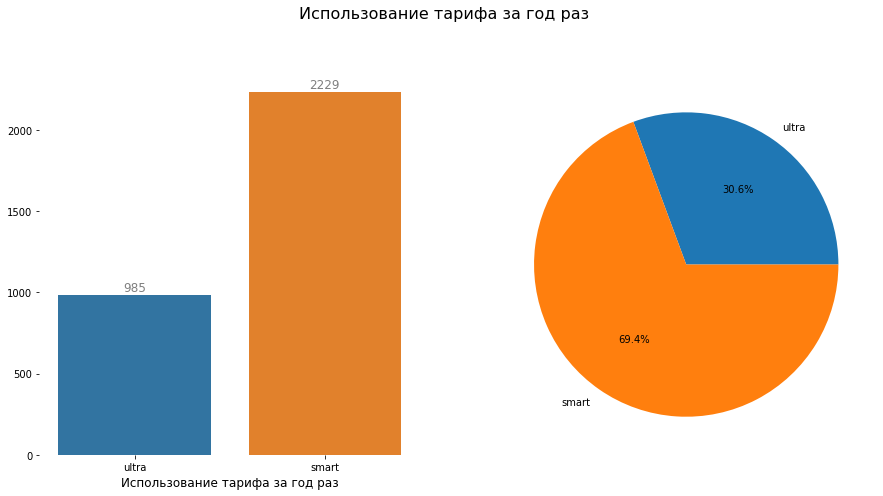


Соотношение тарифа Smart: 69.35 % 2229 шт.
Соотношение тарифа Ultra: 30.65 % 985 шт.


In [ ]:
univariate_multi_plot(df=df, x="tariff", xlabel="Использование тарифа за год раз")

## 4.2 Минуты

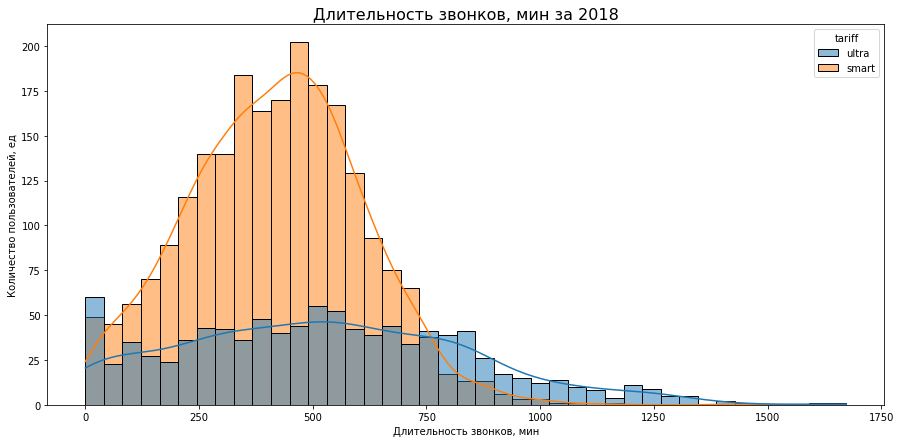


Среднее по количеству минут для тарифа Smart: 417.93
Среднее по количеству минут для тарифа Ultra: 526.62

Сумма по количеству минут для тарифа Smart: 931577
Сумма по количеству минут для тарифа Ultra: 518724

Дисперсия по количеству минут для тарифа Smart: 36203.07
Дисперсия по количеству минут для тарифа Ultra: 100771.22

Стандартное отклонение по количеству минут для тарифа Smart 190.27
Стандартное отклонение по количеству минут для тарифа Ultra 317.44


In [ ]:
hist_def(data=df, x='duration', 
         hue='tariff', xlabel='Длительность звонков, мин', 
         text='по количеству минут для тарифа')

## 4.3 Сообщения

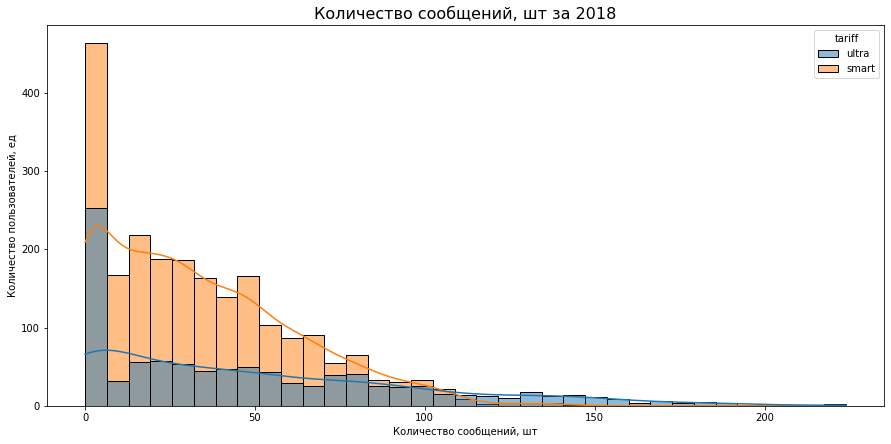


Среднее по количеству сообщений для тарифа Smart: 33.38
Среднее по количеству сообщений для тарифа Ultra: 49.36

Сумма по количеству сообщений для тарифа Smart: 74413
Сумма по количеству сообщений для тарифа Ultra: 48623

Дисперсия по количеству сообщений для тарифа Smart: 796.46
Дисперсия по количеству сообщений для тарифа Ultra: 2282.95

Стандартное отклонение по количеству сообщений для тарифа Smart 28.22
Стандартное отклонение по количеству сообщений для тарифа Ultra 47.78


In [ ]:
hist_def(data=df, x='sms_count', 
         hue='tariff', xlabel='Количество сообщений, шт', 
         text='по количеству сообщений для тарифа')

## 4.4 Интернет трафик

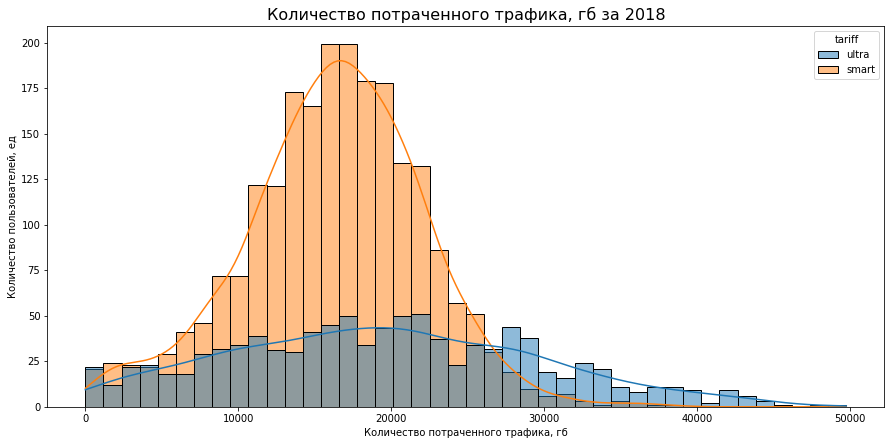


Среднее по количеству гигабайт потраченного трафика для тарифа Smart: 16208.87
Среднее по количеству гигабайт потраченного трафика для тарифа Ultra: 19469.3

Сумма по количеству гигабайт потраченного трафика для тарифа Smart: 36129576
Сумма по количеству гигабайт потраченного трафика для тарифа Ultra: 19177263

Дисперсия по количеству гигабайт потраченного трафика для тарифа Smart: 34447098.49
Дисперсия по количеству гигабайт потраченного трафика для тарифа Ultra: 101648108.89

Стандартное отклонение по количеству гигабайт потраченного трафика для тарифа Smart 5869.17
Стандартное отклонение по количеству гигабайт потраченного трафика для тарифа Ultra 10082.07


In [ ]:
hist_def(data=df, x='mb_used', 
         hue='tariff', xlabel='Количество потраченного трафика, гб', 
         text='по количеству гигабайт потраченного трафика для тарифа')

## 4.5 Выручка

### 4.5.1 Общая сумма выручки

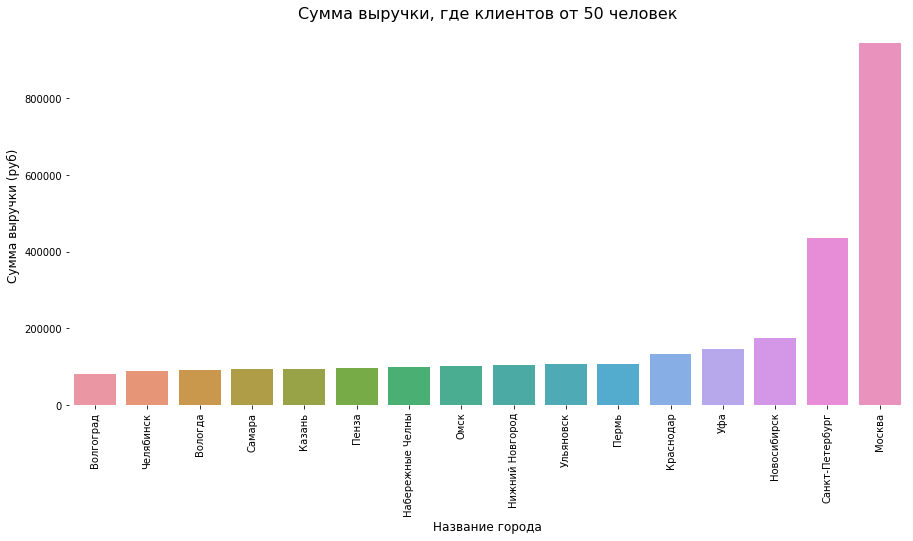

,city,count,sum
75,Москва,611,945042
74,Санкт-Петербург,270,436982
73,Новосибирск,98,174542
72,Уфа,95,145762
71,Краснодар,86,132790
70,Пермь,68,108096
69,Ульяновск,83,106486
68,Нижний Новгород,54,103971
67,Омск,72,103317
66,Набережные Челны,64,100762


In [ ]:
multivariate_plot(x="city", xlabel="Название города", ylable='Сумма', agr='sum', rotation=90, client_cnt=50)

### 4.5.2 Средняя выручка

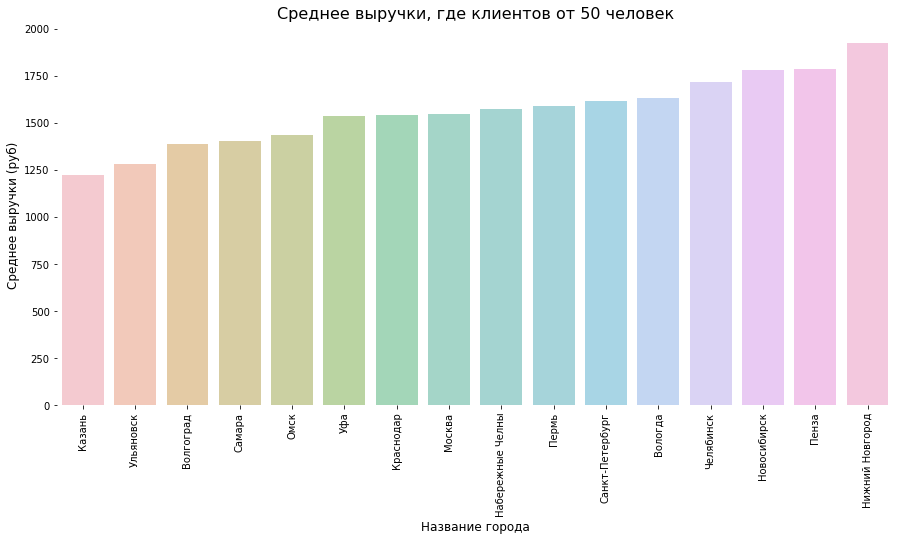

,city,count,mean
65,Нижний Новгород,54,1925.388889
58,Пенза,55,1784.254545
57,Новосибирск,98,1781.040816
55,Челябинск,52,1718.134615
52,Вологда,56,1631.607143
48,Санкт-Петербург,270,1618.451852
46,Пермь,68,1589.647059
44,Набережные Челны,64,1574.406250
40,Москва,611,1546.713584
39,Краснодар,86,1544.069767


In [ ]:
multivariate_plot(x="city", xlabel="Название города", ylable='Среднее', agr='mean', rotation=90, client_cnt=50)

### 4.5.3 Выручка по месяцам

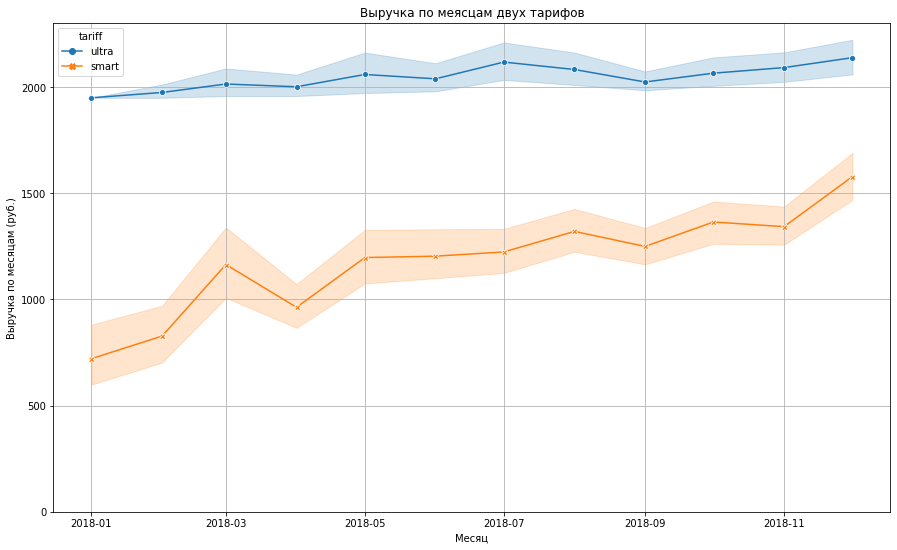

In [ ]:
plt.figure(figsize = (15, 9))
sns.lineplot(data=df, x="month", y="revenue", hue="tariff", style="tariff",
    markers=True, dashes=False)
plt.title('Выручка по меясцам двух тарифов')
plt.xlabel(xlabel='Месяц')
plt.ylabel(ylabel='Выручка по месяцам (руб.)')
plt.grid()
plt.ylim(0)
plt.show()

- Тариф **ultra** показывает стабильно небольшой рост средней выручки по месяцам
- **smart** напротив, демонстрирует стремительный рост в течении года от 750р в январе до 1500 в декабре.


### 4.5.4 Выручка по тарифам

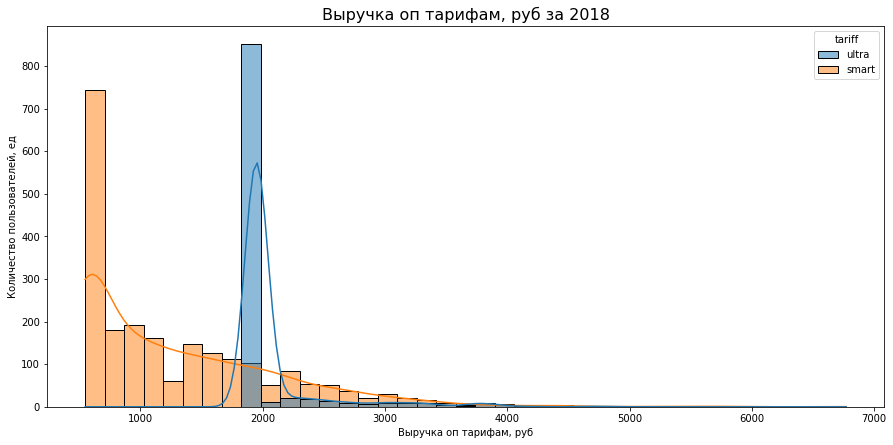


Среднее по выручке для тарифа Smart: 1289.97
Среднее по выручке для тарифа Ultra: 2070.15

Сумма по выручке для тарифа Smart: 2875351
Сумма по выручке для тарифа Ultra: 2039100

Дисперсия по выручке для тарифа Smart: 669485.22
Дисперсия по выручке для тарифа Ultra: 141373.07

Стандартное отклонение по выручке для тарифа Smart 818.22
Стандартное отклонение по выручке для тарифа Ultra 376.0


In [ ]:
hist_def(data=df, x='revenue', 
         hue='tariff', xlabel='Выручка оп тарифам, руб', 
         text='по выручке для тарифа')

# 👩🏼‍🔬 5. Проверка гипотез c помощью t-test

- Ссылка на статью про **необязательное** нормальное распредление для t-критерий (критерий Стьюдента):

[я ссылка](https://koch-kir.medium.com/%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D0%BC%D0%B0%D0%BD%D0%B0-%D0%B8%D0%BB%D0%B8-%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B2-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-55139a5558d)



## 5.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

### 5.1.1 Распределние на qqplot

- посмотрим на рапределение средних выручек пользователей на qq плоте

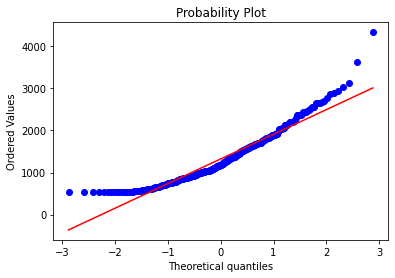

In [ ]:
st.probplot(df.query('tariff == "smart"').groupby('user_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('tariff == "smart"')['revenue'].count()

2229

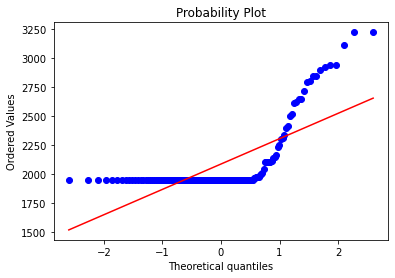

In [ ]:
st.probplot(df.query('tariff != "smart"').groupby('user_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('tariff != "smart"')['revenue'].count()

985

- распредление не нормально, но для критерия Стюдента при большой выборке (более 30 значений) это не обязательно.

### 5.1.2 Формулируем гипотезы

**H0:** средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**


**H1:** средняя выручка пользователей тарифов «Ультра» и «Смарт» **различаются** 

### 5.1.3 Проводим т-тест

In [ ]:
# t-test - Гипотеза о равенстве средних двух генеральных совокупностей
alpha = 0.01

results = st.ttest_ind(
    df.query('tariff == "smart"')['revenue'],
    df.query('tariff == "ultra"')['revenue'],
     equal_var=False)

print('p-значение:', np.round(results.pvalue, decimals=5))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


### Вывод:
- Нулевая гипотеза о равенстве средних выручек двух тарифов, **не подтвердилась.**

## 5.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### 5.2.1 Распределние на qqplot

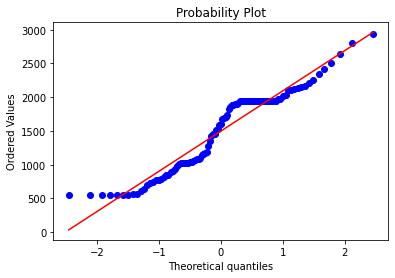

In [ ]:
st.probplot(df.query('city == "Москва"').groupby('user_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('city == "Москва"')['revenue'].count()

611

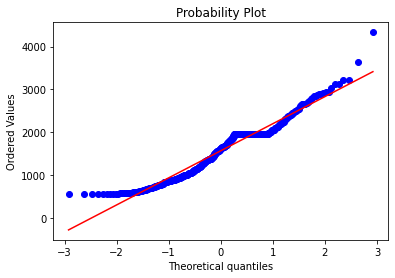

In [ ]:
st.probplot(df.query('city != "Москва"').groupby('user_id')['revenue'].mean(), dist="norm", plot=pylab)
pylab.show()

In [ ]:
df.query('city != "Москва"')['revenue'].count()

2603

- распредление не нормально, но для критерия Стюдента при большой выборке (более 30 значений) это не обязательно.

### 5.2.2 Формулируем гипотезы

**Н0:** средняя выручка пользователей из Москвы **равна** выручке пользователей из других регионов

**Н1:** средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

### 5.2.3 Проводим т-тест

In [ ]:
# t-test - Гипотеза о равенстве средних двух генеральных совокупностей
alpha = 0.01

results = st.ttest_ind(
    df.query('city == "Москва"')['revenue'],
    df.query('city != "Москва"')['revenue'],
     equal_var=False)

print('p-значение:', np.round(results.pvalue, decimals=5))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.52574
Не получилось отвергнуть нулевую гипотезу


### Вывод:
- Нулевая гипотеза о равенстве средних выручек между пользователями из Москвы и из других регионов, **подтвердилась**.

In [ ]:
# t-test - Гипотеза о равенстве средних двух генеральных совокупностей
alpha = 0.01

results = st.ttest_ind(
    df.query('city != "Санкт-Петербург"')['revenue'],
    df.query('city == "Санкт-Петербург"')['revenue'],
     equal_var=False)

print('p-значение:', np.round(results.pvalue, decimals=5))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.08202
Не получилось отвергнуть нулевую гипотезу


# 📝 6. Выводы

 
**портрет пользователя тарифа SMART:**
    
- количество уникальных пользователей тарифа 350 человек        
- тратится в среднем 418 минут (от лимита 84%),
- СМС в среднем на пользователя 34 сообщения (от лимита 67%),
- расход в среднем 17 гб (от лимита 107%),
- всего денег заработано 2,875,351 руб,
- средний чек 1,290 руб
 
 
**портрет пользователя тарифа ULTRA:**
        
- количество уникальных пользователей тарифа 148 человек    
- тратится в среднем 527 минут (от лимита 18%),
- СМС в среднем на пользователя 50 сообщения (от лимита 5%),
- расход в среднем 20 гб (от лимита 64%),
- всего денег заработано 2,039,100 руб,
- средний чек 2,070 руб
 
Тариф SMART более популярный - скорее всего связано с ценой тарифа - 550 руб (ULTRA стоит почти в 4 раза дороже - 1,950 руб).
 
Пользователи практически одинаково говорят по телефону 418 минут и 527 минут в тарифе ULTRA. Интернета в тарифе SMART уже не хватает, идет превышение на 2 гб в месяц. В тарифе ULTRA интернета расходуют 64% от лимита.
 
Средний чек тарифа смарт 1,290 руб, средний чек тарифа ULTRA 2,070 руб, 70%(тариф SMART) пользователей приносят 59% общей выручки, 30%(тариф ULTRA) приносят 41% от общей выручки.
 
> Гипотеза о равенстве средних выручек тарифов, **не подтвердилась.** Средние выручки статистически значимо отличаются.
 
> Гипотеза о равенстве средних выручек между пользователями из Москвы и из других регионов, **подтвердилась**.
 
**В заключении:**
 
- Пользователи тарифа SMART используют лимиты тарифа на 86%, если смотреть по лимиту интернета, то превышают его и переплачивают. Еще можно с уверенностью говорить что в следующем году дополнительно будут платить за минуты. Можно сказать тариф для экономных и рациональных людей.
 
- Пользователи ULTRA используют тариф на 30% от заданых лимитов. С психологической точки зрения им не нужно постоянно следить и проверять остаток лимита, поэтому тариф более комфортный.

**Топ 5 городов по сумме выручки (руб)**
1. Москва 945,042
2. Санкт-Петербург 436,982
3. Новосибирск 174,542
4. Уфа 145,762
5. Краснодар 132,790

**Топ 5 городов по среднему чеку (руб)**
1. Нижний Новгород 1,925
2. Пенза 1,784
3. Новосибирск 1,781
4. Челябинск 1,718
5. Вологда 1,631

